In [3]:
!pip install pandas

!pip install -U scikit-learn

!pip install pyenchant

!pip install language-tool-python

!pip install dtreeviz

!pip install graphviz

In [4]:
import os
import sklearn
import pandas as pd
import csv
import enchant
import numpy as np
import language_tool_python
import dtreeviz
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay
from matplotlib.colors import ListedColormap
from sklearn.metrics import matthews_corrcoef
from sklearn import tree
from matplotlib import pyplot as plt
plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

In [5]:
'''Loading Data into a DataFrame'''
jobsDF = pd.read_csv("archive/fake_job_postings.csv")
jobsDF.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [6]:
#List of urgent phrases we are testing on
urgency_phrases = ['urgent', 'immediate start','once in a lifetime','hurry up',
                   'last chance','don\'t miss out','limited time','quick response',
                   'immediate action','rapid response','must apply','quick hire'
                  ]

#List of jargon we are testing on
jargon = ['handsome', 'dude', 'awesome', 'chill','lame','stoked','cool','hyped',
          'massive','insane','sick','epic','stupid','dumb','buddy','totally','weird',
          'meh','gnarly','bummer','funky','vibes','chitchat','sketchy'          
         ]

#List of "get rich" phrases we are testing on
riches = ['get rich quick','millionare','zero effort','instant wealth','guaranteed profit',
         'easy money','passive income','huge returns','risk free','quick cash','get paid daily',
         'no risks']

In [7]:
 '''
Adding feature columns to the Dateframe
'''

#Token Length Column
def token_length(df):
    df['description_length'] = df['description'].apply(lambda x: len(str(x).split()))

#Description token_ratio
def token_ratio(df):
    df['token_ratio'] = df['description'].apply(lambda x: len(set(str(x).split())) / len(str(x).split()) if len(str(x).split()) > 0 else 0)

#Spelling Error Column
def spelling_error_count(df):
    d = enchant.Dict('en_US')
    errors_count = []
    for description in df['description']:
        desc_words = str(description).split()
        errors_in_desc = sum(not d.check(word) for word in desc_words)
        errors_count.append(errors_in_desc)
    return errors_count

#Check for specific urgent words
def check_urgent(desc):
    return sum(phrase in str(desc).lower() for phrase in urgency_phrases)

#Check for specific urgent jargon
def check_jargon(desc):
    return sum(phrase in str(desc).lower() for phrase in jargon)

#Check for specific promise words
def check_promises(desc):
    return sum(phrase in str(desc).lower() for phrase in riches)

#
def capital_percentage_feature_new(dataset): 
    final = [] 
    for ex in dataset ['description']: 
        description = str(ex). split() 
        total_characters = len(description) 
        capital_count = sum(1 for char in description if char.isupper()) 
        if total_characters == 0: 
            final.append(0.0) 
        else: 
            final.append((capital_count / total_characters) * 100) 
    return final


def repeat_feature(dataset): 
    features = [] 
    for example in dataset['description']: 
        text = str(example) 
        repetitions = {} 
        for i in range(len(text) - 1): 
            pair = text[i:i+2] 
            if pair in repetitions: 
                repetitions[pair] += 1 
            else: repetitions[pair] = 1 
        max_repetitions = max(repetitions. values()) if repetitions else 0 
        features.append(max_repetitions) 
    return features


In [8]:
#All the implementations of the features outlined above
token_length(jobsDF)
jobsDF['spelling_errors'] = spelling_error_count(jobsDF)
jobsDF['urgent'] = jobsDF['description'].apply(check_urgent).astype(int)
jobsDF['jargon'] = jobsDF['description'].apply(check_jargon).astype(int)
jobsDF['promises'] = jobsDF['description'].apply(check_promises).astype(int)
token_ratio(jobsDF)
jobsDF['capitals_percentage'] = capital_percentage_feature_new(jobsDF)
jobsDF['repeated_word_count'] = repeat_feature(jobsDF)

In [10]:
jobsDF.head(3)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,function,fraudulent,description_length,spelling_errors,urgent,jargon,promises,token_ratio,capitals_percentage,repeated_word_count
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,...,Marketing,0,124,25,0,0,0,0.741935,0.806452,31
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,...,Customer Service,0,315,38,0,2,0,0.634921,0.317460,43
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,...,NaN,0,50,4,0,0,0,0.860000,2.000000,10


In [11]:
'''Splitting the data into train and test sets
train_test_split randomly samples jobsDF and splits it into two new data sets 
test_size = 0.10 because we want 10% of our data to be for testing
'''
train, test = train_test_split(jobsDF, test_size=0.10)


In [12]:
'''
splitting again to get our validation set
'''
train, validation = train_test_split(train, test_size=0.111)
print(train.shape[0]) #checking that we have a 80-10-10 split for train valid and test sets
print(test.shape[0])
print(validation.shape[0])

14305
1788
1787


In [54]:
#Check to see if there are enough fradulent records included in the validation set
validation['fraudulent'].value_counts()

fraudulent
0    1694
1      93
Name: count, dtype: int64

In [13]:
'''
We need to have our labels on their own for the clf.fit function below
we do this by creating two new dataframes labels and feature
feature is just our other columns which are our defacto features rn
'''
feature_matrix = ['has_company_logo','telecommuting','has_questions',
                  'description_length','spelling_errors','urgent','jargon',
                  'promises','token_ratio','capitals_percentage','repeated_word_count']

labels = train["fraudulent"] 
feature = train[feature_matrix]
#feature = train.drop(columns=['fraudulent'])

In [14]:
'''
we make a clf object which is a randomforestclassifier
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

'''

clf = RandomForestClassifier(max_depth=60, random_state=0)
clf.fit(feature,labels)
clf.score(feature,labels)

0.999860188745194

In [15]:
'''
We do the same thing for our validation data
'''
labels1 = validation["fraudulent"]
feature1 = validation[feature_matrix]
labels2 = test["fraudulent"]
feature2 = test[feature_matrix]

In [17]:
'''
Our score is already super high because there its only measuring accuracy and there are way more non-fraudulent 
jobs than there are fraudulent ones so we need to check the f1 score instead.
'''
# Create our predictions 
prediction = clf.predict(feature1) 
testprediction = clf.predict(feature2)
# Create confusion matrix from sklearn.metrics 

cm = confusion_matrix(labels1, prediction)
cm2 = confusion_matrix(labels2,testprediction)

# Display F1 score 
score = f1_score(labels1,prediction)
coef = matthews_corrcoef(labels1,prediction)

score2 = f1_score(labels2,testprediction)
coef2 = matthews_corrcoef(labels2,testprediction)
print("Validation Matthew's Coefficient: {}".format(coef))
print("Validation F1 Score: {}".format(score))
print("Validation Confusion Matrix: {}".format(cm))
print("")

print("Test Matthew's Coefficient: {}".format(coef2))
print("Test F1 Score: {}".format(score2))
print("Test Confusion Matrix: {}".format(cm2))

Validation Matthew's Coefficient: 0.634606476894837
Validation F1 Score: 0.5925925925925926
Validation Confusion Matrix: [[1711    1]
 [  43   32]]

Test Matthew's Coefficient: 0.6532969152617716
Test F1 Score: 0.6363636363636364
Test Confusion Matrix: [[1698    5]
 [  43   42]]


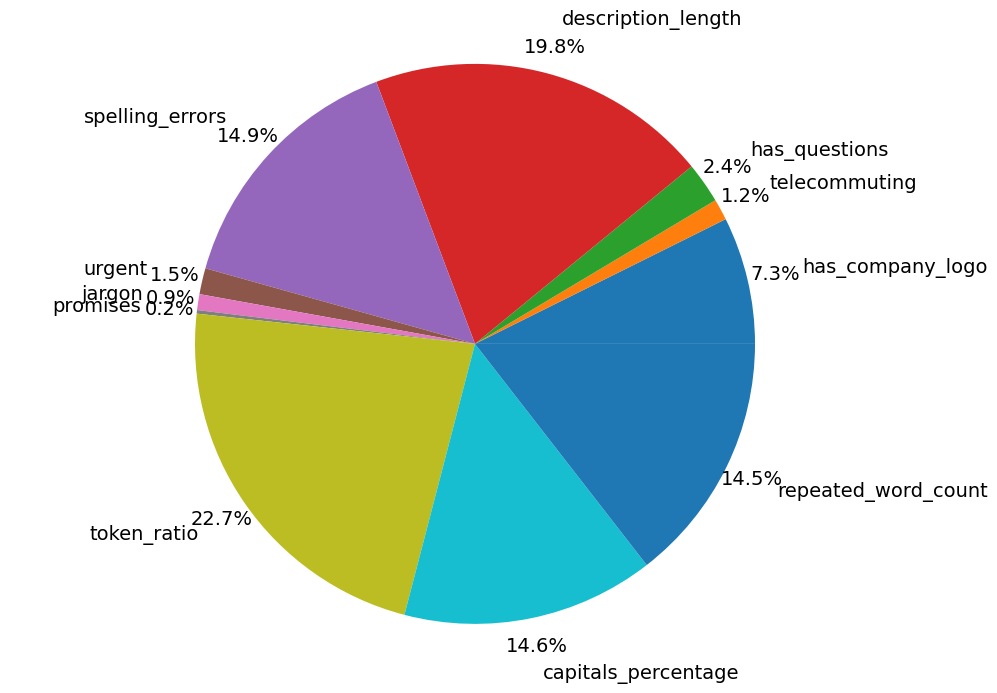

In [18]:
feature_importances = clf.feature_importances_
fig1, ax1 = plt.subplots()
ax1.pie(feature_importances, labels=feature_matrix, autopct='%1.1f%%', pctdistance=1.1, labeldistance=1.2)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('feature_importances.png')
plt.show()


In [19]:
'''
Applying all of the above stuff to our collected job data
'''

IRLjobsDF = pd.read_csv("IRLjobs.csv")
IRLjobsDF.head()


,job_Id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_education,industry,function,fraudulent
0,1,High Ticket Sales\n,NaN,NaN,"120,000-240,000",Get the Free Training where I'll show you how ...,Are you ready to embark on a lucrative journey...,NaN,NaN,1,0,0,NaN,NaN,NaN,Sales,1
1,2,Entrepreneur,NaN,Sales,"150,000-1,000,000","I'm Siena Songbird, nice to meet you! I am a s...",High Ticket Affiliate Marketing Position – Wat...,NaN,NaN,1,0,0,NaN,NaN,Water,Sales,1
2,3,Independent Associate,NaN,NaN,"500,000-25,000,000",Assisting entrepreneurs qualify from $25K - $2...,Make prospective clients a deal they can't ref...,NaN,NaN,1,0,0,Full time,NaN,Finance,NaN,1
3,4,Work from Home,NaN,NaN,"520,000","Welcome. Our company is called, Licensing Expe...","Licensing Experts, Inc. would provide you all ...",NaN,NaN,1,0,0,NaN,NaN,Licensing,NaN,1
4,5,don't leave home,NaN,NaN,"100,000-200,000",Mom and Pop Business Funding,Take your time- ...your life is about to chang...,NaN,NaN,1,0,0,Employee's choice,NaN,Loans,Sales,1


In [20]:
token_length(IRLjobsDF)
IRLjobsDF['urgent'] = jobsDF['description'].apply(check_urgent).astype(int)
IRLjobsDF['jargon'] = jobsDF['description'].apply(check_jargon).astype(int)
IRLjobsDF['promises'] = jobsDF['description'].apply(check_promises).astype(int)
token_ratio(IRLjobsDF)
IRLjobsDF['capitals_percentage'] = capital_percentage_feature_new(IRLjobsDF)
IRLjobsDF['repeated_word_count'] = repeat_feature(IRLjobsDF)
IRLjobsDF['spelling_errors'] = spelling_error_count(IRLjobsDF)

In [21]:

labels = IRLjobsDF["fraudulent"] 
feature = IRLjobsDF[feature_matrix]

prediction = clf.predict(feature) 
# Create confusion matrix from sklearn.metrics |

confusion_matrix(labels, prediction)
# Display accuracy score 
accuracy_score(labels, prediction)
cm = confusion_matrix(labels, prediction)
# Display F1 score 
score = f1_score(labels,prediction)
coef = matthews_corrcoef(labels,prediction)
print("IRL Data Matthew's Coefficient: {}".format(coef))
print("IRL Data F1 Score: {}".format(score))
print("IRL Data Confusion Matrix: {}".format(cm))

IRL Data Matthew's Coefficient: 0.2501558549661309
IRL Data F1 Score: 0.23076923076923078
IRL Data Confusion Matrix: [[63  1]
 [19  3]]


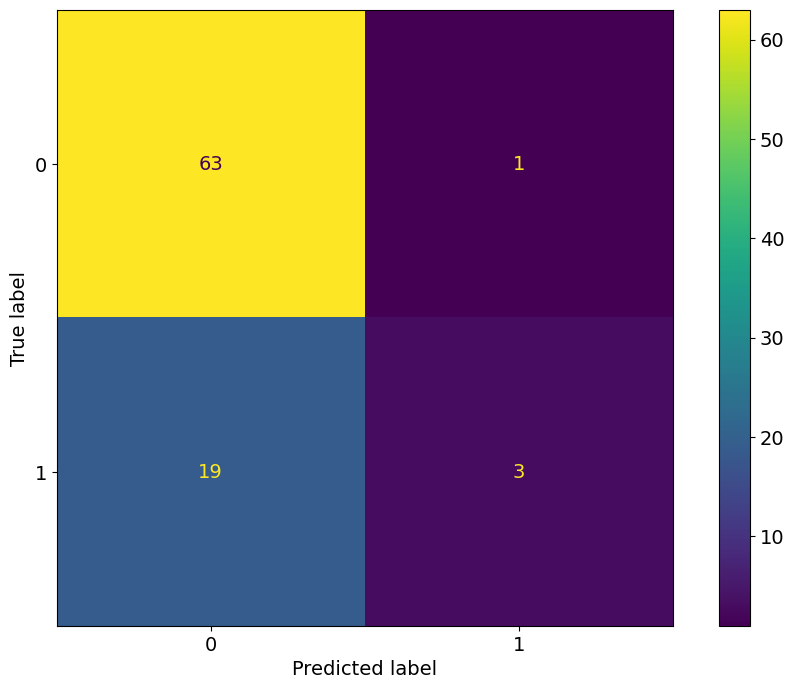

In [22]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_) 
disp.plot()

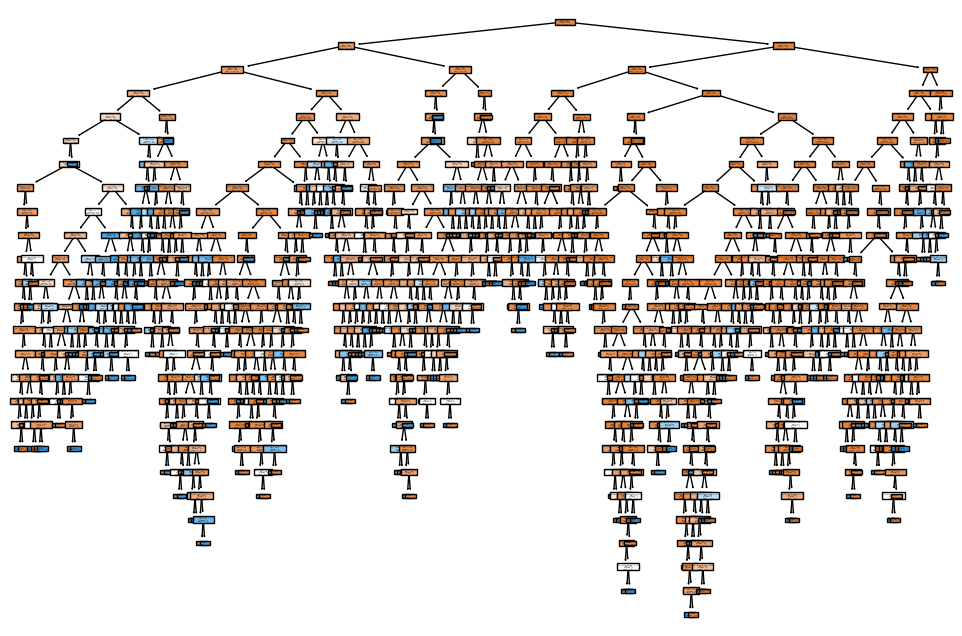

In [63]:
#tree.plot_tree(clf.estimators_[0], feature_names=feature.columns, filled=True)
#plt.savefig('tree.svg',format='svg',bbox_inches = "tight")
'''
DO NOT RUN, this is just for visualzation purposes and it takes a very long time. 
'''

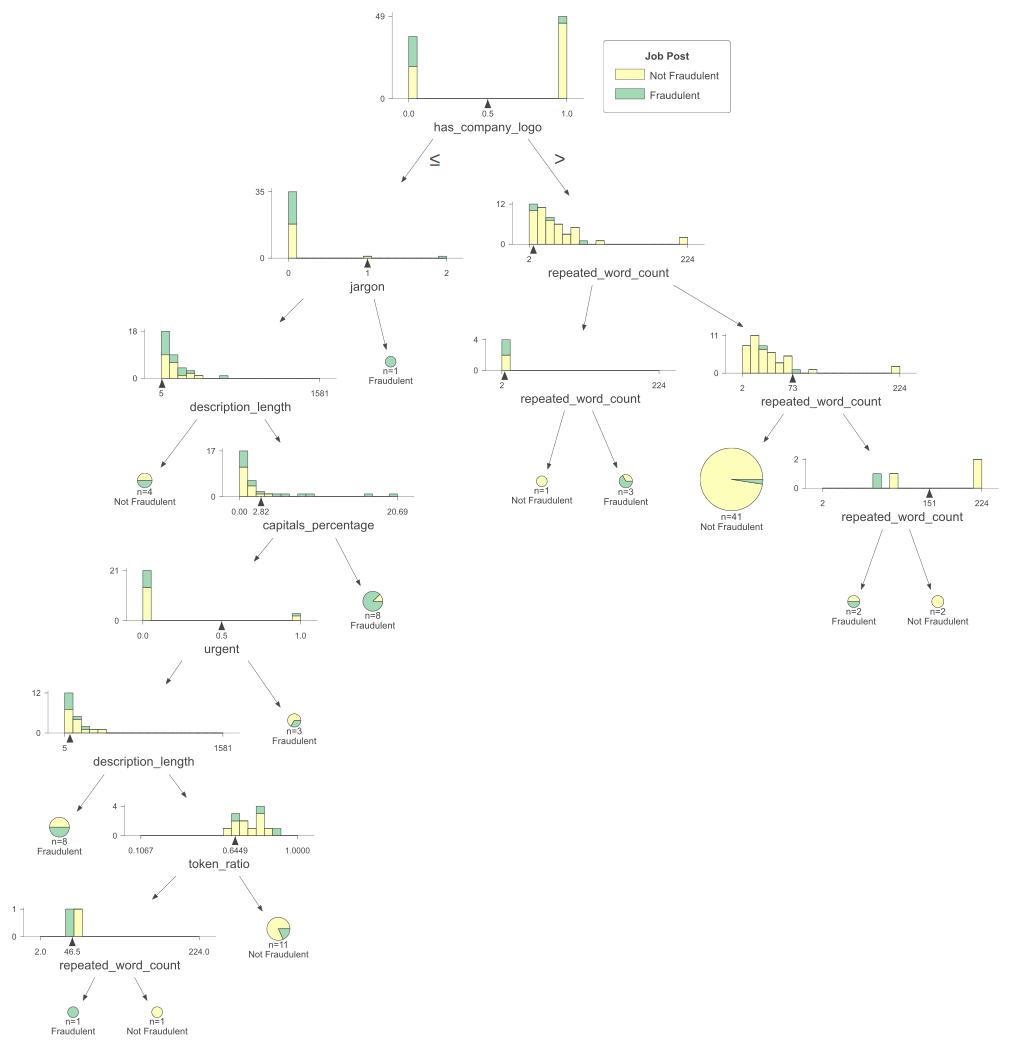

In [37]:
#DO NOT RUN, more vizualization stuff
#from https://stackoverflow.com/questions/75576403/importerror-cannot-import-name-dtreeviz-from-dtreeviz-trees-usr-local-lib

'''
viz = dtreeviz.model(clf.estimators_[0], feature, labels,
           target_name='Job Post',
           feature_names=feature.columns, 
           class_names=["Not Fraudulent", "Fraudulent"])  
viz.view(scale=1.4)

'''
#


In [45]:
def testAverageScore(iterations):
    f1 = []
    f2 = []
    m1 = []
    m2 = []
    for i in range(iterations):
        train, test = train_test_split(jobsDF, test_size=0.10)
        train, validation = train_test_split(train, test_size=0.111)
        labels = train["fraudulent"] 
        feature = train[feature_matrix]
        clf = RandomForestClassifier(max_depth=60, random_state=0)
        clf.fit(feature,labels)
        labels1 = validation["fraudulent"]
        labels2 = test["fraudulent"]
        feature1 = validation[feature_matrix]
        feature2 = test[feature_matrix]
        prediction1 = clf.predict(feature1)
        prediction2 = clf.predict(feature2)
        
        f1.append(f1_score(labels1,prediction1))
        f2.append(f1_score(labels2,prediction2))
        m1.append(matthews_corrcoef(labels1,prediction1))
        m2.append(matthews_corrcoef(labels2,prediction2))
    
    
    fig, axs = plt.subplots(2)
    x = range(iterations)
    axs[0].plot(x, f1,c = '#E07A5F',label = "F1")
    axs[0].plot(x, m1,c= '#81B29A',label = "Matthew's Coef")
    axs[0].set_title('Validation Set')
    axs[0].legend(loc="upper right")
    axs[0].axhline(
          y=np.nanmean(f1), 
          color = '#E07A5F',
          linestyle = '--', 
          linewidth = 3
                        )
    axs[0].axhline(
          y=np.nanmean(m1), 
          color = '#81B29A',
          linestyle = '--', 
          linewidth = 3
                        )
    print("Average F1 score over {} iterations for validation set: {}".format(iterations,(sum(f1) / len(f1))))
    print("Average Matthew's Coefficient over {} iterations for validation set: {}".format(iterations,(sum(m1) / len(m1))))
    print("")
    
    axs[1].plot(x, f2, c = '#E07A5F', label = "F1")
    axs[1].plot(x, m2, c = '#81B29A', label = "Matthew's Coef")
    axs[1].set_title('Test Set')
    axs[1].legend(loc="upper right")
    axs[1].axhline(
          y=np.nanmean(f2), 
          color = '#E07A5F',
          linestyle = '--', 
          linewidth = 3
                        )
    axs[1].axhline(
          y=np.nanmean(m2), 
          color = '#81B29A',
          linestyle = '--', 
          linewidth = 3
                        )
    print("Average F1 score over {} iterations for Test set: {}".format(iterations,(sum(f2) / len(f2))))
    print("Average Matthew's Coefficient over {} iterations for Test set: {}".format(iterations,(sum(m2) / len(m2))))
     
    
        

In [ ]:
testAverageScore(50)